In [2]:
from google.colab import files
upload = files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thedevastator/weather-prediction
!unzip -qq /content/weather-prediction.zip

Saving kaggle.json to kaggle.json
100% 936k/936k [00:00<00:00, 1.10MB/s]
100% 936k/936k [00:00<00:00, 1.10MB/s]


In [3]:
import pandas as pd

df = pd.read_csv('/content/weather_prediction_dataset.csv')
df.head(3)

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6


> 18개의 도시. 도시 별 9개의 날씨 관련 column. 도시 별로 예측값을 구하기  
> 2000~2008년까지 9년치 train, 2009년 1년치 test  
> 1년당 365일  
> 도시별 shape = (365*9, 9)  
> 도시별 loss는 plot하고 전체 도시의 예측값 실제값에 대한 MAE를 하나로 내기

**2000, 2004, 2008년 윤년, 2010년 row 1개**  
총 365 * 9 + 3 + 1 = 3654

**Index**
> 2007.12.31: 2922  
2008.12.31: 3288  
2009.12.31: 3653  

TOURS [-8:]  
STOCKHOLM [-8:-15]  
SONNBLICK [-23:-15]  
ROMA [-31:-23]  

In [ ]:
city = ['BASEL', 'BUDAPEST', 'DE_BILT', 'DRESDEN', 'DUSSELDORF',
        'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MALMO',
        'MONTELIMAR' ,'MUENCHEN', 'OSLO', 'PERPIGNAN', 'ROMA',
        'SONNBLICK', 'STOCKHOLM', 'TOURS']

In [ ]:
df.iloc[:3,-31:-23]

,ROMA_cloud_cover,ROMA_humidity,ROMA_pressure,ROMA_global_radiation,ROMA_sunshine,ROMA_temp_mean,ROMA_temp_min,ROMA_temp_max
0,0,0.72,1.0244,0.92,8.4,1.6,3.0,8.0
1,2,0.74,1.0263,0.81,6.5,4.2,0.0,8.4
2,0,0.77,1.0288,0.89,0.0,3.8,11.1,21.1


In [4]:
def build_data(dataframe, start=None, end=None):
  import keras
  import numpy as np
  import pandas as pd

  '''input'''
  global d, d_arr
  d = dataframe.iloc[:,start:end]
  d_arr = d.to_numpy()
  
  # input standardization
  mean = d_arr.mean(axis=0)
  d_arr -= mean
  std = d_arr.std(axis=0)
  d_arr /= std

  '''target'''
  for col in d.columns:
    if 'temp_mean' in col:
      target = d[[col]]
      target_arr = target.to_numpy()
      # print(col)

  '''dataset argument 조정'''
  num_train_samples = int(0.5 * len(d_arr))
  num_val_samples = int(0.25 * len(d_arr))
  sampling_rate = 2
  global sequence_length
  sequence_length = 20 # 각 데이터 샘플의 입력 시퀀스 길이를 1D 텐서로 지정
  delay = sampling_rate * (sequence_length + 24 - 1) # target으로 사용할 미래의 time step
  batch_size = 32
  # print(delay)

  '''dataset 구성'''
  train_dataset = keras.utils.timeseries_dataset_from_array(
      d_arr[:-delay],
      targets=target_arr[delay:],
      sampling_rate=sampling_rate,
      sequence_length=sequence_length,
      shuffle=True,
      batch_size=batch_size,
      start_index=0,
      end_index=2923)
  # print(len(d_arr[:-delay]))

  val_dataset = keras.utils.timeseries_dataset_from_array(
      d_arr[:-delay],
      targets=target_arr[delay:],
      sampling_rate=sampling_rate,
      sequence_length=sequence_length,
      shuffle=True,
      batch_size=batch_size,
      start_index=2923-sequence_length,
      end_index=3289-sequence_length)

  # print(num_train_samples + num_val_samples)
  test_dataset = keras.utils.timeseries_dataset_from_array(
      d_arr[:-delay],
      targets=target_arr[delay:],
      sampling_rate=sampling_rate,
      sequence_length=sequence_length,
      shuffle=True,
      batch_size=batch_size,
      start_index=3289)


  print('num_train_samples:', num_train_samples)
  print('num_val_samples:', num_val_samples)
  print('num_test_samples:', len(d_arr) - num_train_samples - num_val_samples)
  print()
  print('train_dataset:', len(train_dataset))
  print('val_dataset:', len(val_dataset))
  print('test_dataset:', len(test_dataset))
  print()
  for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

  return train_dataset, val_dataset, test_dataset

In [5]:
train_dataset, val_dataset, test_dataset = build_data(df, -31, -23)

num_train_samples: 1827
num_val_samples: 913
num_test_samples: 914

train_dataset: 91
val_dataset: 11
test_dataset: 8

샘플 크기: (32, 20, 8)
타깃 크기: (32, 1)


In [6]:
from tensorflow import keras
from keras import layers

In [8]:
def LSTM():
  # from tensorflow import keras
  # from keras import layers
  
  inputs = layers.Input(shape=(sequence_length, d_arr.shape[-1]))
  x = layers.Flatten()(inputs)
  x = layers.LSTM(16, recurrent_dropout=0.2, return_sequences=True)(inputs)
  # x = layers.LSTM(8, recurrent_dropout=0.2)(x)
  x = layers.Dropout(0.5)(x)
  outputs = layers.Dense(1)(x)
  model = keras.Model(inputs, outputs)

  return model


In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]

model = LSTM()
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset,
                    callbacks=callbacks,
                    verbose=1)

model = keras.models.load_model("jena_dense.keras")

Epoch 1/100
91/91 [==============================] - 11s 72ms/step - loss: 276.7128 - mae: 15.2590 - val_loss: 264.7028 - val_mae: 14.9799
Epoch 2/100
91/91 [==============================] - 6s 69ms/step - loss: 206.9875 - mae: 12.7170 - val_loss: 191.9956 - val_mae: 12.1681
Epoch 3/100
91/91 [==============================] - 6s 71ms/step - loss: 156.2284 - mae: 10.6057 - val_loss: 148.6127 - val_mae: 10.2831
Epoch 4/100
91/91 [==============================] - 6s 71ms/step - loss: 125.1382 - mae: 9.2660 - val_loss: 118.2534 - val_mae: 8.9723
Epoch 5/100
91/91 [==============================] - 6s 70ms/step - loss: 102.7118 - mae: 8.2880 - val_loss: 95.0397 - val_mae: 7.9353
Epoch 6/100
91/91 [==============================] - 6s 68ms/step - loss: 86.5038 - mae: 7.5920 - val_loss: 77.3768 - val_mae: 7.1202
Epoch 7/100
91/91 [==============================] - 6s 70ms/step - loss: 75.6058 - mae: 7.1175 - val_loss: 64.5924 - val_mae: 6.5425
Epoch 8/100
91/91 [===========================

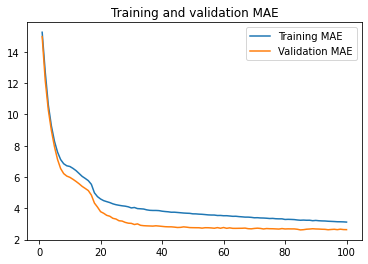

In [10]:
import matplotlib.pyplot as plt
mae = history.history["mae"]
val_mae = history.history["val_mae"]
epochs = range(1, len(mae) + 1)
plt.figure()
plt.plot(epochs, mae, label="Training MAE")
plt.plot(epochs, val_mae, label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [11]:
model = keras.models.load_model('/content/jena_dense.keras')
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

8/8 [==============================] - 0s 9ms/step - loss: 15.9269 - mae: 3.2385
테스트 MAE: 3.24
